# CNN을 이용한 Quark/Gluon Jet 분류 예제

이 노트북에서는 **입력 크기 33×33**인 Jet 이미지를 **Convolutional Neural Network (CNN)** 으로 분류하는 과정을 단계별로 다룹니다.

**이 예제의 목표**  
1. 데이터 구조와 기본 전처리 과정을 이해한다.  
2. `torch.utils.data.Dataset`을 활용해 데이터셋을 구현한다.  
3. Conv → BatchNorm → ReLU → Pooling 블록으로 구성된 간단한 CNN 아키텍처를 설계한다.  
4. 학습/검증 루프를 직접 구현하여 성능을 모니터링한다.  
5. 최종 모델을 저장하고, 새로운 데이터에 대해 추론해 본다.

각 단계마다 **개념 설명**과 **실습 코드**를 번갈아 배치하였으니, 천천히 따라오며 CNN의 전체 파이프라인을 학습해 보세요.



## 1. 환경 설정

먼저 필요한 라이브러리를 설치 및 로드하고, **GPU가 사용 가능한지** 확인합니다.




In [ ]:
import torch
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.6.0+cu124
Using device: cuda


## 2. 데이터 준비

이 단계에서는 **레이블 정보가 담긴 CSV 파일**과 **이미지 파일들이 저장된 폴더 구조**를 살펴봅니다.  
데이터를 어떻게 관리해야 하는지, 그리고 코드에서 어떻게 참조하는지 명확히 이해하는 것이 중요합니다.

---

### 2.1 CSV 파일 구조

- 파일명: `labels.csv`  
- 위치: 프로젝트 루트의 `dataset/MC` 폴더 안  
- 내용: 이미지 파일 이름과 해당 이미지의 클래스 레이블을 담고 있는 2개의 컬럼

| 컬럼명    | 데이터 타입 | 설명                                                   |
|-----------|-------------|--------------------------------------------------------|
| `filename` | 문자열      | 이미지 파일명 (예: `jet_000001.png`)   |
| `label`    | 정수(0 또는 1) | 클래스 레이블<br>  • 0 = gluon<br>  • 1 = quark      |

> **예시**  
> ```csv
> filename,label
> jet_00001.png,0
> jet_00002.png,1
> jet_00003.png,0
> jet_00004.png,1
> ```
>
> - 첫 번째 행(`heatmap_00001.png,0`)은  
>   - `heatmap_00001.png` 파일이 gluon(0) 클래스임을 나타냅니다.  
> - CSV 파일은 **헤더 포함**이며, 파이썬 `pandas.read_csv()`로 바로 로드할 수 있습니다.

---

### 2.2 이미지 폴더 구조

- 이미지가 저장된 디렉터리: `dataset/`  
- CSV의 `filename` 컬럼 값과 **완전히 일치**하는 파일명이 존재해야 합니다.







In [9]:
# MC 데이터셋 전용
import pandas as pd

csv_path = "/content/drive/MyDrive/예제/dataset/MC/labels.csv"
df = pd.read_csv(csv_path)
df.head()

,filename,label
0,jet_000000.png,1
1,jet_000001.png,1
2,jet_000002.png,1
3,jet_000003.png,1
4,jet_000004.png,1


In [2]:
# heatmap 데이터셋 전용
import pandas as pd

csv_path = "/content/drive/MyDrive/예제/dataset/heatmap_resized/labels.csv"
df = pd.read_csv(csv_path)
df.head()

,filename,label
0,heatmap_00000.png,0
1,heatmap_00001.png,1
2,heatmap_00002.png,1
3,heatmap_00003.png,0
4,heatmap_00004.png,0


## 3. Dataset 클래스 정의

`JetDataset`은 CSV 파일에 기록된 **이미지 파일명**과 **레이블**을 읽어서,  
PyTorch `DataLoader`가 **(이미지 Tensor, 레이블)** 쌍을 반복 처리할 수 있도록 해 주는 커스텀 데이터셋입니다.

---

### 3.1 전체 흐름

 1. `__init__(self, csv_file, root_dir, transform=None)`

  - **역할**: CSV 로드 및 기본 설정  
  - **파라미터**:  
      - `csv_file` (str) : 이미지 파일명과 레이블이 저장된 CSV 파일 경로
      - `root_dir` (str) : 실제 이미지들이 저장된 디렉터리  
      - `transform` (callable, optional) : PIL 이미지를 Tensor로 변환하거나 데이터 증강을 적용하는 함수  
  - **동작**  
      1. `self.df = pd.read_csv(csv_file)`로 DataFrame에 파일명·레이블 로드  
      2. `self.root_dir`, `self.transform`을 멤버 변수에 저장  


 2. `__len__(self)`

  - **역할**: 데이터셋 크기 반환  


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import os

class JetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label


## 4. 데이터 전처리(transformations) 및 DataLoader 구성

이제 **학습용(train)과 검증용(validation)** 데이터에 각각 알맞은 전처리(transformations)를 적용하고, 이를 반복 처리할 `DataLoader`를 만들어 보겠습니다.

---

### 4.1 Train/Validation 분할

- **목적**: 모델이 학습 중에 본 적 없는 데이터로 성능을 평가하기 위함  
- `sklearn.model_selection.train_test_split` 사용  
  - `test_size=0.2` → 전체의 20%를 검증용으로 분리  
  - `stratify=df['label']` → 클래스 비율(0/1) 유지  
  - `random_state=42` → 재현 가능한 분할  

---

### 4.2 Transform 정의

| 용도       | 적용 순서 & 설명                                                                                     |
|------------|------------------------------------------------------------------------------------------------------|
| **학습용** | ToTensor()` — PIL→Tensor 변환 |
| **검증용** | ToTensor()` — PIL→Tensor 변환 |

---

### 4.3 Dataset 객체 생성

- 앞서 구현한 `JetDataset`에 `train_labels.csv`·`val_labels.csv`와  
  각기 다른 `transform`을 넘겨 줍니다.

---

### 4.4 DataLoader 생성

- **배치 크기**(`batch_size`)를 적절히 설정 (예: 128)  
- **shuffle**  
  - 학습용: `shuffle=True` (배치마다 무작위 순서로 섞어 학습 안정화)  
  - 검증용: `shuffle=False` (평가 결과 재현성 보장)  
- **num_workers**  
  - Windows: `0` 권장  
  - Linux/Mac: CPU 코어 수만큼 설정 가능 (예: `4`)

---

### 4.5 전체 흐름

1. **Train/Validation 분할**  
   - `train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)`로 원본 `df`를 80% 학습, 20% 검증으로 분할  
   - `train_labels.csv`와 `val_labels.csv` 파일로 저장  

2. **Transform 정의**  
   - 학습/검증 모두 PIL 이미지를 텐서로 변환하는 `transforms.ToTensor()` 적용  

3. **Dataset 인스턴스 생성**  
   - `train_ds = JetDataset("…/train_labels.csv", root_dir, train_tf)`  
   - `val_ds   = JetDataset("…/val_labels.csv",   root_dir, val_tf)`  

4. **DataLoader 생성**  
   - `train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=True)`  
   - `val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)`  

5. **학습/검증 루프 사용**  
   - `for images, labels in train_loader:` → 모델에 배치 단위로 입력  
   - `for images, labels in val_loader:`  → 검증용 데이터 순차 입력  


이제 `train_loader`와 `val_loader`를 통해 **미니배치 단위**로 데이터를 모델에 공급할 준비가 완료되었습니다!  



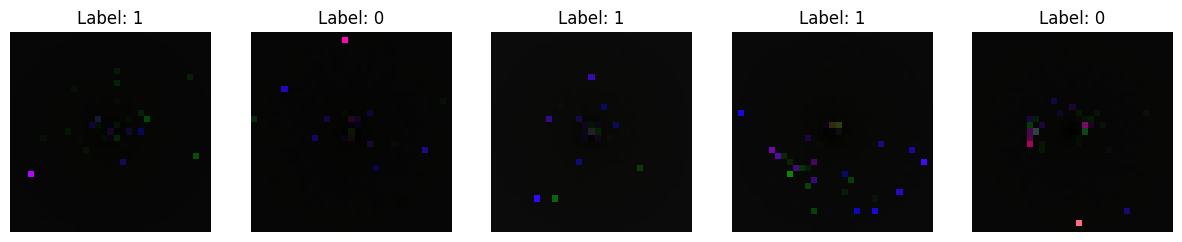

In [13]:
# MC 데이터셋 전용
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# train/val CSV 분할
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv("/content/drive/MyDrive/예제/dataset/MC/train_labels.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/예제/dataset/MC/val_labels.csv", index=False)

train_tf = transforms.ToTensor()
val_tf = transforms.ToTensor()

train_ds = JetDataset("/content/drive/MyDrive/예제/dataset/MC/train_labels.csv", "/content/drive/MyDrive/예제/dataset/MC", train_tf)
val_ds   = JetDataset("/content/drive/MyDrive/예제/dataset/MC/val_labels.csv",   "/content/drive/MyDrive/예제/dataset/MC", val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i+4]  # Tensor [C, H, W]
    img = img.permute(1, 2, 0)       # [H, W, C]
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()


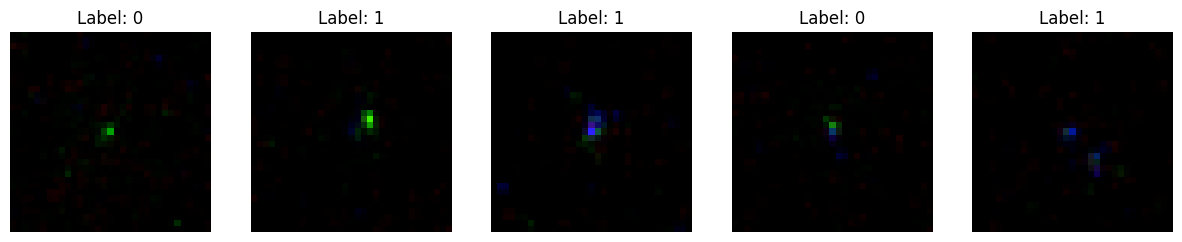

In [8]:
# heatmap 데이터셋 전용

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# train/val CSV 분할
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv("/content/drive/MyDrive/예제/dataset/heatmap_resized/train_labels.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/예제/dataset/heatmap_resized/val_labels.csv", index=False)

train_tf = transforms.ToTensor()
val_tf = transforms.ToTensor()

train_ds = JetDataset("/content/drive/MyDrive/예제/dataset/heatmap_resized/train_labels.csv", "/content/drive/MyDrive/예제/dataset/heatmap_resized", train_tf)
val_ds   = JetDataset("/content/drive/MyDrive/예제/dataset/heatmap_resized/val_labels.csv",   "/content/drive/MyDrive/예제/dataset/heatmap_resized", val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i+5]  # Tensor [C, H, W]
    img = img.permute(1, 2, 0)       # [H, W, C]
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

## 5. Conv → BatchNorm → ReLU → Pooling 블록 쌓기

이번 셀에서는 **입력 크기 33×33 픽셀** 이미지를, **Convolution → BatchNorm → ReLU → MaxPool** 블록을 3회 거쳐 점차 축소·추출한 후, Fully Connected 레이어로 분류하는 전체 구조를 설명합니다.

---

### 5.1 하나의 Conv 블록 구성

1. **Conv2d**  
   - **역할**: 입력 채널에서 출력 채널로 특징(feature) 추출  
   - **파라미터**:  
     - `in_channels` → 이전 블록의 출력 채널 (첫 블록은 RGB 3채널)  
     - `out_channels` → 추출할 특징 수 (32, 64, 128 순서로 증가)  
     - `kernel_size=3`, `padding=1` → 공간 크기 유지 (33→33)  

2. **BatchNorm2d**  
   - **역할**: 미니배치 단위로 활성화값 정규화 → 학습 안정성 및 수렴 속도 개선  

3. **ReLU**  
   - **역할**: 비선형 활성화 적용 → 복잡한 패턴 학습  

4. **Dropout2d** (학습 시)  
   - **역할**: 채널 단위 드롭아웃 → 과적합 방지  

5. **MaxPool2d(kernel_size=2)**  
   - **역할**: 공간 해상도 절반 축소(다운샘플링) → 계산량 감소 및 요약된 특징  

---

### 5.2 블록별 채널 & 공간 크기 변화

| 블록 번호 | 입력 공간 크기 | Conv 후 크기 | Pool 후 크기 | 채널 (in→out) |
|:---------:|:-------------:|:-----------:|:-----------:|:-------------:|
| Block 1   | 33×33         | 33×33       | 16×16       | 3 → 32        |
| Block 2   | 16×16         | 16×16       | 8×8         | 32 → 64       |
| Block 3   | 8×8           | 8×8         | 4×4         | 64 → 128      |

---

### 5.3 Fully Connected 레이어

- **입력**: `128 채널 × 4 × 4 공간` → `Flatten()` → 길이 2048 벡터  
- **히든**: `Linear(2048, 128)` + `ReLU` + `Dropout(0.5)`  
- **출력**: `Linear(128, 2)` → 클래스 수(2)  
- **손실함수**: `CrossEntropyLoss` (내부적으로 softmax + 로그 연산)

---

### 5.4 전체 흐름

1. **conv1 블록**  
   - 입력: RGB 이미지 `(B, 3, 33, 33)`  
   - `Conv2d(3→32, kernel=3, padding=1)` → `BatchNorm2d(32)` → `ReLU` → `Dropout2d(0.25)` → `MaxPool2d(2)`  
   - 출력: `(B, 32, 16, 16)`

2. **conv2 블록**  
   - 입력: `(B, 32, 16, 16)`  
   - `Conv2d(32→64, kernel=3, padding=1)` → `BatchNorm2d(64)` → `ReLU` → `Dropout2d(0.5)` → `MaxPool2d(2)`  
   - 출력: `(B, 64, 8, 8)`

3. **conv3 블록**  
   - 입력: `(B, 64, 8, 8)`  
   - `Conv2d(64→128, kernel=3, padding=1)` → `BatchNorm2d(128)` → `ReLU` → `Dropout2d(0.5)` → `MaxPool2d(2)`  
   - 출력: `(B, 128, 4, 4)`

4. **Fully Connected (fc) 블록**  
   - `Flatten()` → 길이 `128×4×4 = 2048` 벡터  
   - `Linear(2048→128)` → `ReLU` → `Dropout(0.5)`  
   - `Linear(128→2)` → 최종 **raw logits** 출력  

5. **forward 함수**  
   ```python
   x = conv1(x)   # (B,32,16,16)
   x = conv2(x)   # (B,64, 8, 8)
   x = conv3(x)   # (B,128,4, 4)
   out = fc(x)    # (B,2)
   return out


In [ ]:
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Dropout2d(0.25), nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Dropout2d(0.5), nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Dropout2d(0.5), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(x)

model = CNNClassifier().to(device)
model

CNNClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

## 6. 한 에포크 처리 함수 정의 (train_epoch / eval_epoch)
---
### 6.1 손실 함수(Criterion) 및 옵티마이저(Optimizer) 설정

- **Criterion**: `nn.CrossEntropyLoss()`  
  - 분류 문제에서 **raw logits**를 입력으로 받아 내부적으로 softmax + 로그 연산을 수행  
  - 클래스 간 확률 분포 차이를 측정하는 표준 손실 함수  

- **Optimizer**: `optim.Adam(model.parameters(), lr=1e-3)`  
  - 모델의 모든 학습 가능한 파라미터(`model.parameters()`)를 대상으로  
  - 학습률(`lr`) 0.001로 어댑티브한 가중치 업데이트 수행  
  - 초매개변수: 베타값, 가중치 감쇠 등 기본값 사용

---

### 6.2 `run_epoch(loader, train=True)` 함수 설명

이 함수는 **데이터로더**와 **학습 여부 플래그**만으로 한 에포크를 처리하고, 평균 손실과 정확도를 반환합니다.

---

### 6.3 전체 흐름

1. **모드 설정**  
   - `train=True` → `model.train()` → Dropout/BatchNorm이 학습 모드  
   - `train=False`→ `model.eval()`  → Dropout 비활성화, BatchNorm 평가 모드  

2. **그라디언트 관리**  
   - 학습 시: `torch.enable_grad()` → 역전파 기울기 계산  
   - 검증 시: `torch.no_grad()`   → 기울기 비활성화(메모리·속도 최적화)  

3. **배치별 처리**  
   - **데이터 로드**: `(imgs, labels) = loader`  
   - **디바이스 전송**: `imgs.to(device)`, `labels.to(device)`  

4. **순전파(Forward Pass)**  
   - `outputs = model(imgs)` → 배치별 로짓 획득  
   - `loss = criterion(outputs, labels)` → 배치 손실 계산  

5. **역전파 및 가중치 업데이트** *(학습 모드만)*  
   - `optimizer.zero_grad()` → 이전 기울기 초기화  
   - `loss.backward()`        → 현재 손실에 대한 기울기 계산  
   - `optimizer.step()`       → 가중치 갱신  

6. **메트릭 집계**  
   - **손실 누적**: `total_loss += loss.item() * batch_size`  
   - **정확도 누적**: `preds = outputs.argmax(1)`, `(preds == labels).sum()`  
   - **샘플 수 누적**: `total += batch_size`  

7. **평균 계산**  
   - `avg_loss = total_loss / total`  
   - `avg_acc  = total_correct / total`  

8. **반환**  
   - `(avg_loss, avg_acc)` 형태로 반환하여 호출부에서 출력/저장/시각화에 사용  

---

이 구조 덕분에 학습과 검증 코드를 **중복 없이** 하나의 함수로 처리할 수 있으며,  
학습 루프에서는 `run_epoch(train_loader, train=True)` 와  
검증 루프에서는 `run_epoch(val_loader, train=False)` 만 호출하면 됩니다.  




In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total = 0, 0, 0

    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()

            preds = outputs.argmax(1)
            total_loss += loss.item() * imgs.size(0)
            total_correct += (preds == labels).sum().item()
            total += imgs.size(0)

    return total_loss/total, total_correct/total




## 7. 학습 루프 실행 및 손실·정확도 출력

이번 셀에서는 앞서 정의한 `run_epoch` 함수를 활용해 **매 에포크(epoch)**마다 **학습(train)**과 **검증(validation)** 단계를 순차적으로 실행하고,  
에포크별 **손실(loss)** 및 **정확도(accuracy)**를 화면에 출력하며 결과를 기록하는 과정을 구현합니다.

---

### 7.1 전체 흐름

1. **학습 단계**  
   - `run_epoch(train_loader, model, criterion, optimizer, device)` 호출  
   - 학습 모드로 순전파·역전파·가중치 업데이트  
   - 에포크당 평균 손실(`train_loss`)과 정확도(`train_acc`) 반환  

2. **검증 단계**  
   - `run_epoch(val_loader, model, criterion, None, device)` 호출  
   - 평가 모드로 순전파만 수행 (`optimizer=None` → `model.eval()` 동작)  
   - 에포크당 평균 손실(`val_loss`)과 정확도(`val_acc`) 반환  

3. **결과 출력**  
   - 터미널 또는 노트북 출력창에 포맷에 맞춰 문자열 출력  
   - 예:  
     ```
     Epoch  1/20 │ Train loss=0.5432, acc=0.7431 │ Val loss=0.6210, acc=0.7025
     ```

4. **메트릭 저장**  
   - 이후 시각화나 로그 분석을 위해, 리스트(`train_losses`, `val_accs` 등)에 값을 추가

---



In [ ]:
from tqdm import tqdm

num_epochs = 10

# 1) 메트릭 저장용 리스트 초기화
train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

for epoch in range(1, num_epochs + 1):
    # 2) 학습 단계 (train=True) + 진행바
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    tr_loss, tr_acc = run_epoch(train_bar, train=True)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)

    # 3) 검증 단계 (train=False) + 진행바
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]  ")
    val_loss, val_acc = run_epoch(val_bar, train=False)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 4) 에포크별 결과 출력
    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")



Epoch 1/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]


Epoch 1/10 | Train: loss=0.6444, acc=0.6458 | Val:   loss=0.6293, acc=0.6470


Epoch 2/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]


Epoch 2/10 | Train: loss=0.6297, acc=0.6615 | Val:   loss=0.6145, acc=0.6620


Epoch 3/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 12.73it/s]


Epoch 3/10 | Train: loss=0.6267, acc=0.6580 | Val:   loss=0.6020, acc=0.6760


Epoch 4/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]


Epoch 4/10 | Train: loss=0.6073, acc=0.6725 | Val:   loss=0.5943, acc=0.6830


Epoch 5/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 11.84it/s]


Epoch 5/10 | Train: loss=0.6133, acc=0.6745 | Val:   loss=0.5946, acc=0.6890


Epoch 6/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]


Epoch 6/10 | Train: loss=0.6050, acc=0.6870 | Val:   loss=0.5999, acc=0.6870


Epoch 7/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 11.23it/s]


Epoch 7/10 | Train: loss=0.6051, acc=0.6875 | Val:   loss=0.5923, acc=0.6840


Epoch 8/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]


Epoch 8/10 | Train: loss=0.6035, acc=0.6850 | Val:   loss=0.6009, acc=0.6830


Epoch 9/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]


Epoch 9/10 | Train: loss=0.5901, acc=0.7027 | Val:   loss=0.5997, acc=0.6870


Epoch 10/10 [Val]  : 100%|██████████| 32/32 [00:02<00:00, 12.00it/s]

Epoch 10/10 | Train: loss=0.5967, acc=0.6975 | Val:   loss=0.5843, acc=0.6950


## 8. 모델 저장 및 간단 추론

이번 셀에서는 학습이 완료된 CNN 모델의 **가중치를 저장**하고, **저장된 가중치**를 불러와 검증 데이터셋의 한 샘플에 대해 **추론**을 수행하는 전체 과정을 설명합니다.

---

### 8.1 전체 흐름

1. **모델 가중치 저장**  
   - `torch.save(model.state_dict(), "cnn_heatmap_classifier.pth")`를 사용해  
     학습된 가중치만 `"cnn_heatmap_classifier.pth"` 파일에 저장합니다.

2. **평가 모드 전환**  
   - `model.eval()`을 호출하여 Dropout과 BatchNorm이 평가 모드로 동작하도록 설정합니다.

3. **샘플 불러오기**  
   - `img, label = val_ds[0]`로 검증용 데이터셋(`val_ds`)의 첫 번째 이미지와 실제 레이블을 가져옵니다.

4. **배치 차원 추가 & 디바이스 이동**  
   - `img.unsqueeze(0)`을 통해 배치 크기 1을 나타내는 차원을 추가하고,  
   - `.to(device)`로 GPU(또는 CPU) 메모리로 텐서를 전송합니다.

5. **추론 및 예측 클래스 결정**  
   - `model(input_tensor)`로 로짓(logits)을 얻은 뒤,  
   - `.argmax(dim=1).item()`을 사용해 가장 높은 값의 인덱스를 예측 클래스(`pred`)로 선택합니다.

6. **결과 출력**  
   - `print("실제 레이블:", label, "예측:", pred)`로 실제 레이블과 모델 예측값을 콘솔에 표시합니다.

---

이 과정을 통해 저장된 모델 가중치를 로드하여 **간단한 한 줄의 코드**로 바로 추론을 수행해 볼 수 있습니다.  




In [ ]:
# MC 데이터셋 전용

# 1) 모델 저장
torch.save(model.state_dict(), "cnn_classifier_MC.pth")

# 2) 모델 로드 & 평가 모드 전환
model.load_state_dict(torch.load("cnn_classifier_MC.pth", map_location=device))
model.eval()

# 3) 테스트 폴더에서 첫 번째 파일 선택
test_dir = "/content/drive/MyDrive/예제/dataset/MC/test"
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".png")])


# 4) 레이블 매핑 로드 (전체 데이터셋의 labels.csv)
labels_df = pd.read_csv(os.path.join(test_dir, "labels.csv"))
labels_map = dict(zip(labels_df['filename'], labels_df['label']))
class_names = {0: "gluon", 1: "quark"}

# 5) transform 정의
transform = transforms.ToTensor()  # 또는 Normalize 포함 transform


# 6) 추론
for fname in test_files[:5]: # 다섯개 이미지 예측
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()

    actual_idx = labels_map.get(fname, None)
    print("────────────────────────────────────────")
    print(f"이미지:        {fname}")
    print(f"실제 레이블:   {actual_idx} ({class_names.get(actual_idx, 'unknown')})")
    print(f"예측 레이블:   {pred_idx} ({class_names[pred_idx]})")



────────────────────────────────────────
이미지:        jet_005000.png
실제 레이블:   1 (quark)
예측 레이블:   1 (quark)
────────────────────────────────────────
이미지:        jet_005001.png
실제 레이블:   0 (gluon)
예측 레이블:   1 (quark)
────────────────────────────────────────
이미지:        jet_005002.png
실제 레이블:   1 (quark)
예측 레이블:   1 (quark)
────────────────────────────────────────
이미지:        jet_005003.png
실제 레이블:   0 (gluon)
예측 레이블:   1 (quark)
────────────────────────────────────────
이미지:        jet_005004.png
실제 레이블:   1 (quark)
예측 레이블:   1 (quark)


In [ ]:
# MC 데이터셋 전용

# 1) 모델 저장
torch.save(model.state_dict(), "cnn_classifier_heatmap.pth")

# 2) 모델 로드 & 평가 모드 전환
model.load_state_dict(torch.load("cnn_classifier_heatmap.pth", map_location=device))
model.eval()

# 3) 테스트 폴더에서 첫 번째 파일 선택
test_dir = "/content/drive/MyDrive/예제/dataset/heatmap_resized/test"
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".png")])


# 4) 레이블 매핑 로드 (전체 데이터셋의 labels.csv)
labels_df = pd.read_csv(os.path.join(test_dir, "labels.csv"))
labels_map = dict(zip(labels_df['filename'], labels_df['label']))
class_names = {0: "gluon", 1: "quark"}

# 5) transform 정의
transform = transforms.ToTensor()  # 또는 Normalize 포함 transform


# 6) 추론
for fname in test_files[:1]: # 다섯개 이미지 예측
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()

    actual_idx = labels_map.get(fname, None)
    print("────────────────────────────────────────")
    print(f"이미지:        {fname}")
    print(f"실제 레이블:   {actual_idx} ({class_names.get(actual_idx, 'unknown')})")
    print(f"예측 레이블:   {pred_idx} ({class_names[pred_idx]})")


테스트 이미지: heatmap_05090.png
실제 레이블:   0 (gluon)
예측 레이블:   1 (quark)
